In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

from sklearn.svm import SVC

# specific helper functions for feature extraction
import features

from sklearn.model_selection import learning_curve

# tell matplotlib that we plot in a notebook
%matplotlib notebook

In [2]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = './normalized_images/'
# where do you want to save your features and other outputs:
output_path = './normalized_output/'

In [3]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

In [4]:
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

In [6]:
descriptor_desired = 'daisy'

In [7]:
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

Number of encoded train images: 4042


In [8]:
with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

Number of encoded test images: 4035


In [9]:
# learn the codebook for the 'daisy' features from the training data

codebook_size = 1700

clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)

training took 402.37312626838684 seconds


In [10]:
# encode all train images 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

In [11]:
# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

In [12]:
# use a labelencoder to obtain numerical labels
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

Learning Curve


<IPython.core.display.Javascript object>


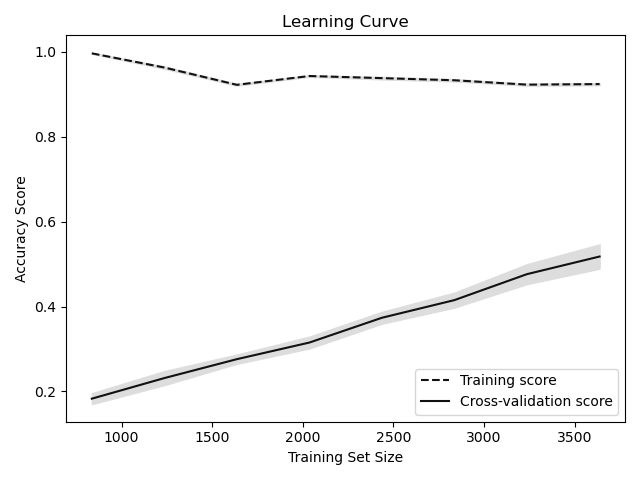

In [13]:
X, y = train_data, train_labels

print("Learning Curve")

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVC(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [14]:
#SVM

# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(train_data, train_labels)

predictions=svm.predict_proba(test_data)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename(f'SVM_normalized_{descriptor_desired.upper()}_{codebook_size}', 'csv'))
helpers.writePredictionsToCsv(predictions, pred_file_path, label_strings)